In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

plt.rcParams.update({'font.size': 18})

## Load the Capacity data
- Three datasets: Train, Test1, Test2, Test3

In [2]:
number_cells = [41,42,40,45] # train and three tests
dataset = ['train', 'test1', 'test2', 'test3']

all_Q_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_Q = pd.read_csv("Dataset/discharge_capacity/"+dataset[myset]+"/cell"+str(cell+1)+".csv", 
                               header = None, names=['cycle_no', 'capacity', 'initial_capacity'])
        cell_Q['cell_no'] = cell+1 # cell number
        cell_Q['norm_Q'] = cell_Q['capacity']/cell_Q['initial_capacity'].iloc[0] # cell number
        cell_Q['dataset'] = dataset[myset]
        all_Q_curves = pd.concat([all_Q_curves, cell_Q], axis=0)

## Plot the capacity curves

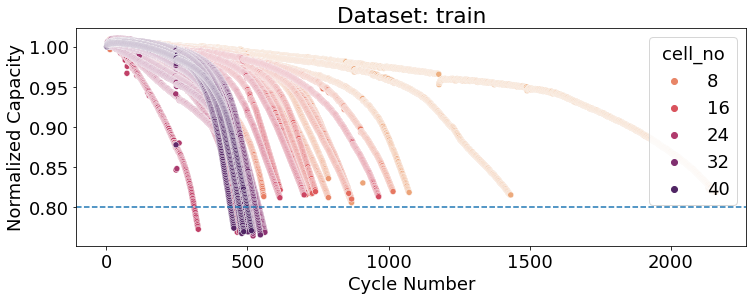

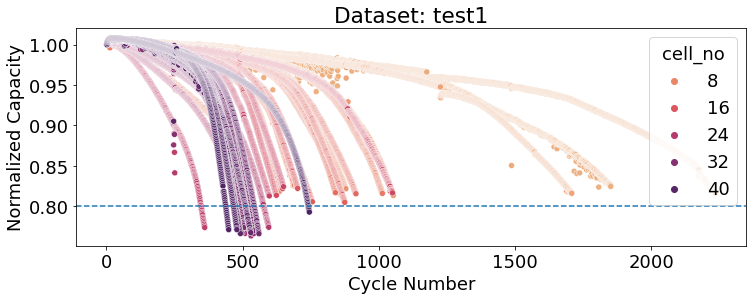

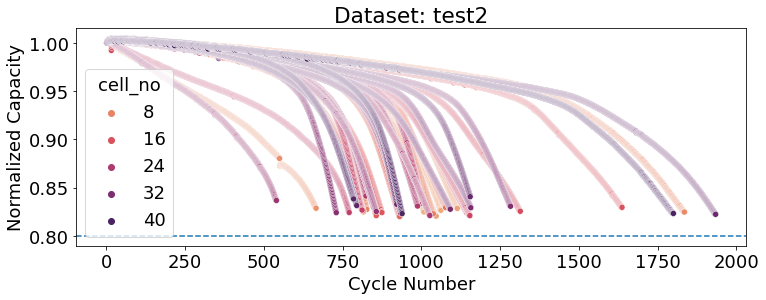

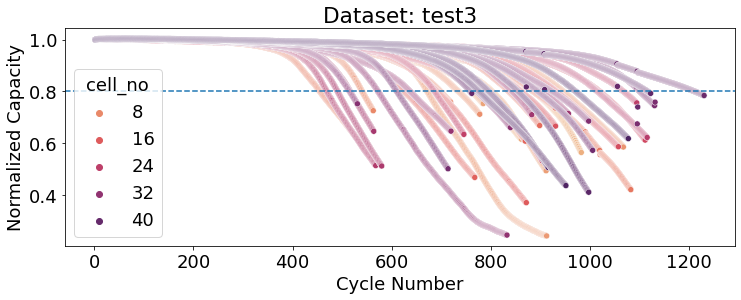

In [3]:
for myset in range(len(dataset)):
    fig = plt.figure(figsize=(12,4))
    sns.scatterplot(
        data=all_Q_curves.loc[all_Q_curves['dataset']==dataset[myset]], 
        x="cycle_no", y="norm_Q", hue="cell_no", palette="flare"
    )
    plt.axhline(0.8, linestyle='dashed')
    plt.title("Dataset: "+ dataset[myset])
    plt.xlabel("Cycle Number")
    plt.ylabel("Normalized Capacity")

## Load the VQ curve data

### We will use VQ(cycle=100)-VQ(cycle=10) as feature to determine RUL

In [4]:
VQcol_names = ["cycle_"+str(i+1) for i in range(150)]
all_VQ_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_VQ = pd.read_csv("Dataset/V_Q_curve/"+dataset[myset]+"/cell"+str(cell+1)+".csv", header = None,
                               names=VQcol_names)
        cell_VQ['voltage'] = np.linspace(3.5,2,cell_VQ.shape[0])
        cell_VQ['diff_cycle100_cycle10'] = cell_VQ['cycle_100']-cell_VQ['cycle_10']
        cell_VQ['cell_no'] = cell+1 # cell number
        cell_VQ['dataset'] = dataset[myset]
        all_VQ_curves = pd.concat([all_VQ_curves, cell_VQ], axis=0)

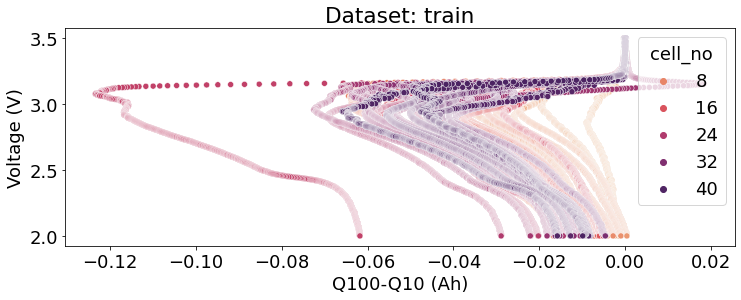

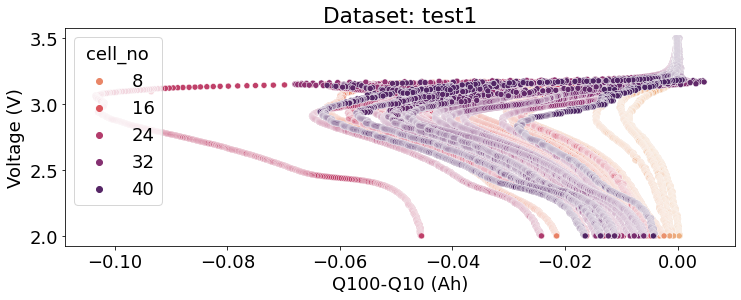

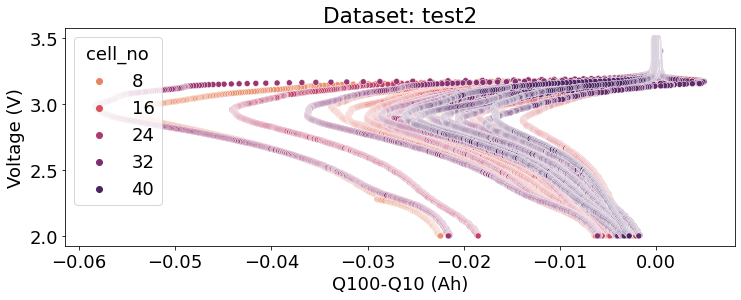

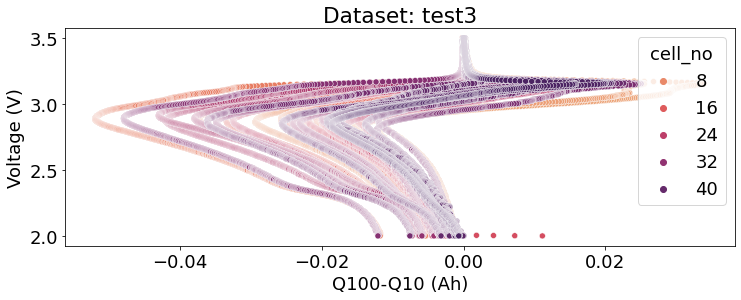

In [5]:
for myset in range(len(dataset)):
    fig = plt.figure(figsize=(12,4))
    sns.scatterplot(
        data=all_VQ_curves.loc[all_VQ_curves['dataset']==dataset[myset]], 
        x="diff_cycle100_cycle10", y="voltage", hue="cell_no", palette="flare"
    )
    plt.title("Dataset: "+ dataset[myset])
    plt.xlabel("Q100-Q10 (Ah)")
    plt.ylabel("Voltage (V)")

In [6]:
all_VQ_curves.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000295,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000259,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000225,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000193,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000163,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train


In [7]:
all_VQ_curves.groupby(by=['dataset', 'cell_no']).var().reset_index()

,dataset,cell_no,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,...,cycle_143,cycle_144,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10
0,test1,1,0.178752,0.179241,0.179079,0.179453,0.179358,0.179632,0.179590,0.179506,...,0.177868,0.177846,0.177759,0.177704,0.177670,0.177508,0.177683,NaN,0.188063,0.000009
1,test1,2,0.181725,0.182183,0.181989,0.182463,0.182225,0.182640,0.182494,0.182277,...,0.180655,0.180659,0.180621,0.180616,0.180548,0.180525,0.180546,NaN,0.188063,0.000011
2,test1,3,0.182167,0.182007,0.181987,0.182112,0.182336,0.182235,0.182355,0.182331,...,0.179545,0.179510,0.179463,0.179449,0.179423,0.179420,0.179379,NaN,0.188063,0.000025
3,test1,4,0.182607,0.182857,0.183438,0.183404,0.183316,0.183366,0.183376,0.183458,...,0.176391,0.176259,0.176179,0.176167,0.176036,0.176073,0.175996,NaN,0.188063,0.000169
4,test1,5,0.182917,0.183044,0.183438,0.183402,0.183329,0.183819,0.183975,0.183916,...,0.178252,0.178320,0.178365,0.178328,0.178260,0.178228,0.178179,NaN,0.188063,0.000105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,train,37,0.182196,0.182502,0.182961,0.182664,0.182682,0.183001,0.182762,0.182846,...,0.170665,0.170499,0.170139,0.170217,0.170072,0.169928,0.169949,NaN,0.188063,0.000308
164,train,38,0.183576,0.183577,0.184326,0.184238,0.184364,0.184615,0.184484,0.184521,...,0.170353,0.170470,0.170269,0.169122,0.170035,0.169658,0.169626,NaN,0.188063,0.000353
165,train,39,0.179789,0.179786,0.179393,0.180324,0.180193,0.179621,0.180416,0.180068,...,0.168280,0.168657,0.167971,0.167886,0.168248,0.167921,0.168274,NaN,0.188063,0.000207
166,train,40,0.182214,0.182752,0.182559,0.182490,0.182954,0.183030,0.183081,0.183180,...,0.167826,0.167731,0.167097,0.167074,0.167128,0.166798,0.166745,NaN,0.188063,0.000476


In [8]:
all_cycle_lives = pd.DataFrame()
for myset in range(len(dataset)):
    cycle_lives = pd.read_csv("Dataset/cycle_lives/"+dataset[myset]+"_cycle_lives.csv", header = None,
                             names=['cycle_life']).reset_index()
    cycle_lives['cell_no'] = cycle_lives['index'] + 1
    cycle_lives['dataset'] = dataset[myset]
    
    all_cycle_lives = pd.concat([all_cycle_lives, cycle_lives.drop('index', axis=1)], axis=0)

In [9]:
all_cycle_lives.head()

,cycle_life,cell_no,dataset
0,2160,1,train
1,1434,2,train
2,1074,3,train
3,870,4,train
4,788,5,train


In [10]:
all_VQ_curves_merge = pd.merge(all_VQ_curves, all_cycle_lives, how='left',
                               left_on = ['dataset', 'cell_no'], right_on = ['dataset', 'cell_no'])
all_VQ_curves_merge_agg = all_VQ_curves_merge.groupby(by=['cell_no', 'dataset']).agg({'diff_cycle100_cycle10':'var',
                                                            'cycle_life': 'mean'}).reset_index()

## Data Visualization
(similar to the Nature Energy paper)

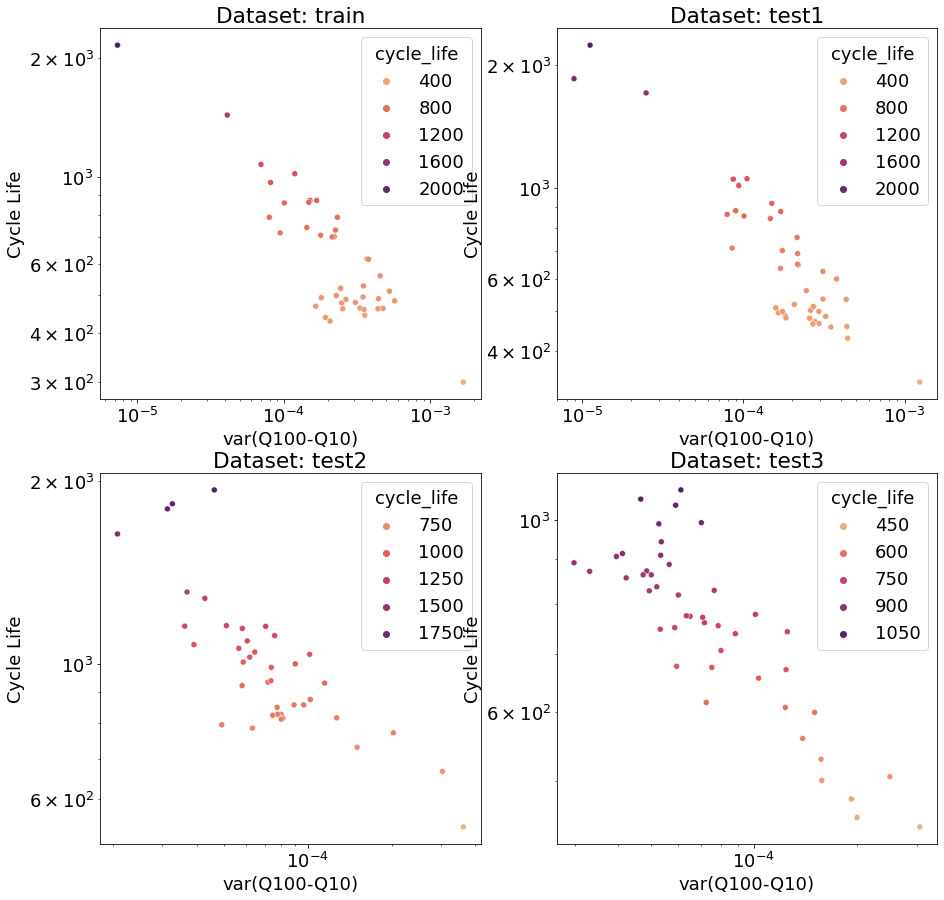

In [11]:
fig, ax = plt.subplots(2,2,figsize=(15, 15))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    sns.scatterplot(
        data=all_VQ_curves_merge_agg.loc[all_VQ_curves_merge_agg['dataset']==dataset[myset]], 
        x="diff_cycle100_cycle10", y="cycle_life", hue="cycle_life", palette="flare", ax = myax
    )
    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("var(Q100-Q10)")
    myax.set_ylabel("Cycle Life")
    myax.set_xscale('log')
    myax.set_yscale('log')

In [12]:
all_VQ_curves_merge.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset,cycle_life
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train,2160
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train,2160
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train,2160
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train,2160
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train,2160


## Make Input-Output for training the UQ models
Input:- VQ(100)-VQ(10)

Output:- cycle life

In [13]:
def get_input_output(df, myset):
    df_myset = df.loc[df['dataset']==myset]
    X, Y = [], []
    for mycell in sorted(set(df_myset['cell_no'])):
        X.append(df_myset.loc[df_myset['cell_no']==mycell].sort_values(
            by='voltage', ascending = False, axis = 0)['diff_cycle100_cycle10'].values)
        Y.append(df_myset.loc[df_myset['cell_no']==mycell]['cycle_life'].mean())
    return X, np.expand_dims(Y, axis=1)

In [14]:
Xtrain, Ytrain = get_input_output(all_VQ_curves_merge, 'train')
Xtest1, Ytest1 = get_input_output(all_VQ_curves_merge, 'test1')
Xtest2, Ytest2 = get_input_output(all_VQ_curves_merge, 'test2')
Xtest3, Ytest3 = get_input_output(all_VQ_curves_merge, 'test3')

scalerX = MinMaxScaler()
Xtrain_norm, Ytrain_norm  = scalerX.fit_transform(Xtrain), (Ytrain)/np.max(Ytrain)
Xtest1_norm, Ytest1_norm  = scalerX.transform(Xtest1), (Ytest1)/np.max(Ytrain)
Xtest2_norm, Ytest2_norm  = scalerX.transform(Xtest2), (Ytest2)/np.max(Ytrain)
Xtest3_norm, Ytest3_norm  = scalerX.transform(Xtest3), (Ytest3)/np.max(Ytrain)

## Uncertainty Model 1: Deep Ensemble (DE)

- Use of Gaussian Layer that outputs - mean and aleatoric variance
- Use of Negative Log Likelihood loss
- Ensemble to capture epistematic uncertainty

In [15]:
# loss function and new custom layer to give mean and standard deviation
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((sigma)) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), (sigma))) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [16]:
def generate_trained_DEmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dense(10, activation = actfn)(x)
      
    mu, sigma = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

In [17]:
## Create 20 models and select some based on training error
prediction_fns, train_mae = [], []
nmodels = 10
nepochs = 300

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
    train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
    prediction_fns.append(my_func)
    
nmodels_select = 5
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])

2022-10-16 13:59:05.930631: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100% |#########################################################################|


In [18]:
def get_ensemble(df, UQmodelcode, nmodels_select):
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = df[mu_cols].mean(axis=1)
    if UQmodelcode=="DE":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             + np.mean(df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    df[UQmodelcode+"_mu_eff"] = mu_eff
    df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return df

allresults_df = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nmodels_select):
        result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
        result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

    result_df = get_ensemble(result_df, "DE", nmodels_select)
    allresults_df = pd.concat([allresults_df, result_df], axis = 0)
allresults_df.head()

,True,dataset,DE_mu_0,DE_sigma_0,DE_mu_1,DE_sigma_1,DE_mu_2,DE_sigma_2,DE_mu_3,DE_sigma_3,DE_mu_4,DE_sigma_4,DE_mu_eff,DE_sigma_eff
0,2160.0,train,1598.271973,226.278976,1923.187378,300.154419,2023.585449,171.145081,1589.880127,194.147079,1240.920532,378.451508,1675.169189,383.710510
1,1434.0,train,1366.481934,190.461044,1296.541016,279.900482,1458.318359,164.465073,1107.122925,174.608719,1095.726074,381.265076,1264.838135,289.745789
2,1074.0,train,1045.923462,150.121338,1021.648682,271.459442,1094.902832,162.177002,874.701965,165.912537,909.482971,385.003448,989.332031,258.143372
3,870.0,train,794.957031,124.454659,777.110657,264.148529,891.426697,160.799072,709.664734,160.000565,817.159546,386.865570,798.063782,246.466660
4,788.0,train,935.685364,138.148956,947.149536,269.213379,1134.433228,161.486099,778.565491,162.458344,1029.733887,382.609100,965.113464,268.050476


## Results - Visualization

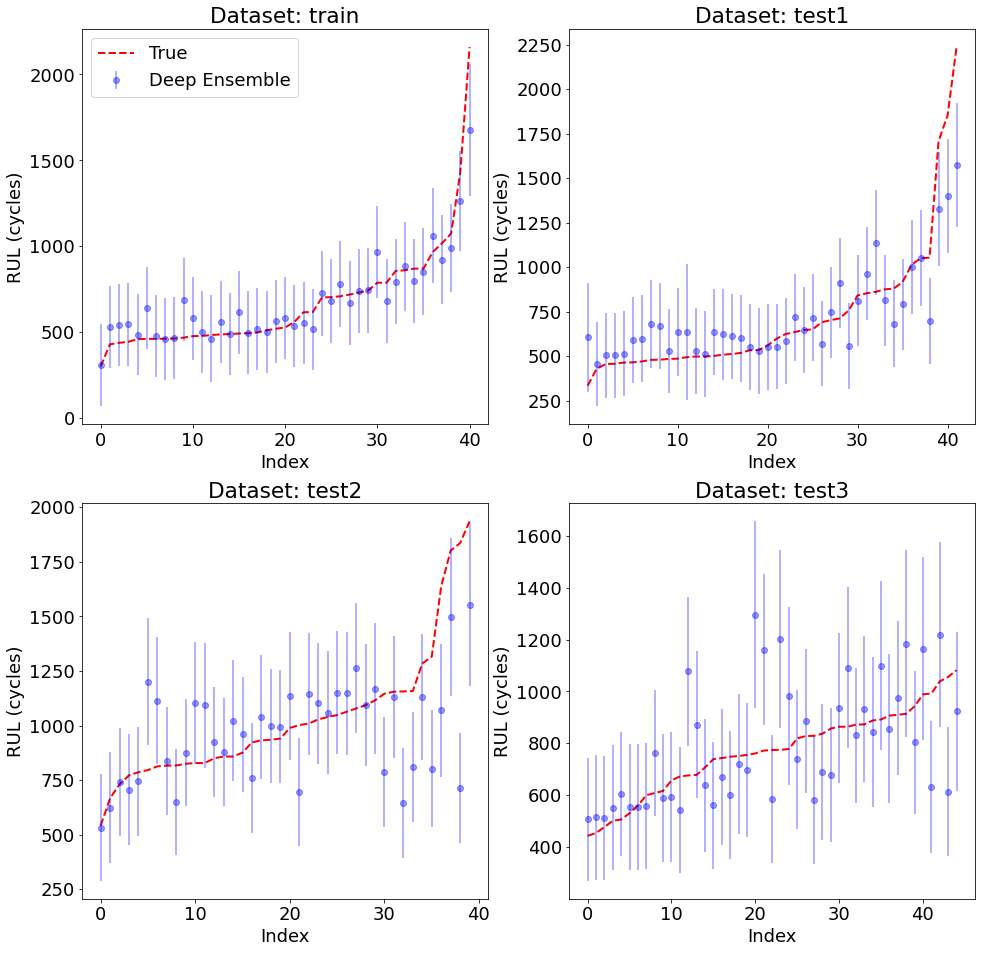

In [19]:
allresults_df_sorted = allresults_df.sort_values(by='True', ascending=True)
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_df_sorted.loc[allresults_df_sorted['dataset']==dataset[myset]]
    myax.plot(range(df.shape[0]), df['True'], 
             color='red', linestyle='dashed', linewidth=2, label='True')
    myax.errorbar(range(df.shape[0]), df['DE_mu_eff'], 
                 yerr = df['DE_sigma_eff'],
                 fmt='o', color='blue', alpha = 0.4, label='Deep Ensemble')
    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Index")
    myax.set_ylabel("RUL (cycles)")
    if myset ==0:
        myax.legend()

In [20]:
allresults_df_sorted.head()

,True,dataset,DE_mu_0,DE_sigma_0,DE_mu_1,DE_sigma_1,DE_mu_2,DE_sigma_2,DE_mu_3,DE_sigma_3,DE_mu_4,DE_sigma_4,DE_mu_eff,DE_sigma_eff
20,300.0,train,288.423431,99.599487,323.467072,263.149811,309.063995,149.503693,313.439941,151.591599,300.642456,401.351929,307.007385,239.284348
21,335.0,test1,450.681152,98.181694,476.541840,255.104233,961.782959,147.061142,455.825470,151.406693,689.437866,389.276947,606.853882,305.869446
38,429.0,train,473.919434,98.991295,549.235718,257.559998,581.099609,162.463440,496.068390,152.682297,552.787415,392.323975,530.622131,239.814774
40,429.0,test1,470.340546,98.306786,454.899780,254.862762,441.024689,162.048340,487.659058,152.396790,427.771820,394.899719,456.339172,237.604446
21,438.0,train,491.681366,99.690964,556.414978,257.759216,563.558716,162.145920,521.046631,153.509369,568.222168,391.986359,540.184753,238.412582


In [21]:
def get_confidence_interval(y_true, mu, sigma):
    alphas = np.linspace(1e-10, 1-1e-10, 1000)
    myCI=[]
    for myalpha in sorted(alphas):
        intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        myCI.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    return 100*alphas, 100*np.array(myCI)  # converting to percentages

In [22]:
alphas, CI_DE = get_confidence_interval(allresults_df_sorted['True'].values, 
                                       allresults_df_sorted['DE_mu_eff'].values, 
                                       allresults_df_sorted['DE_sigma_eff'].values)


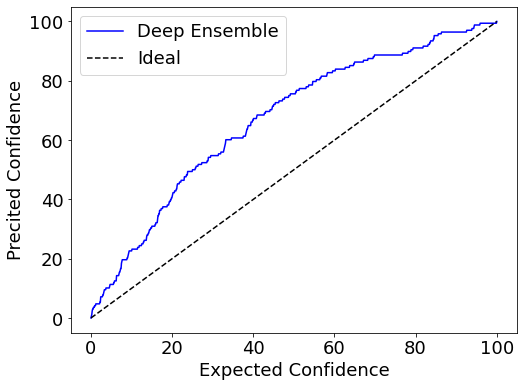

In [23]:
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='Deep Ensemble')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

## Repeat the above algorithm for 10 times to capture variations

In [24]:
## Multiple runs
niter = 10
allCI_DE = np.zeros((1000, niter))
pbar=ProgressBar()

for myiter in pbar(range(niter)):
    prediction_fns=[]
    train_mae=[]
    for i in range(nmodels):
        my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
        train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
        prediction_fns.append(my_func)

    nmodels_select = 5
    final_DE_fns = []
    for i in range(nmodels_select):
        final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])

    allresults_df = pd.DataFrame()
    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        for i in range(nmodels_select):
            result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
            result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

        result_df = get_ensemble(result_df, "DE", nmodels_select)
        allresults_df = pd.concat([allresults_df, result_df], axis = 0)
    allresults_df.head()

    allresults_df_sorted = allresults_df.sort_values(by='True', ascending=True)

    alphas, CI_DE = get_confidence_interval(allresults_df_sorted['True'].values, 
                                           allresults_df_sorted['DE_mu_eff'].values, 
                                           allresults_df_sorted['DE_sigma_eff'].values)
    allCI_DE[:,myiter] = CI_DE

100% |#########################################################################|


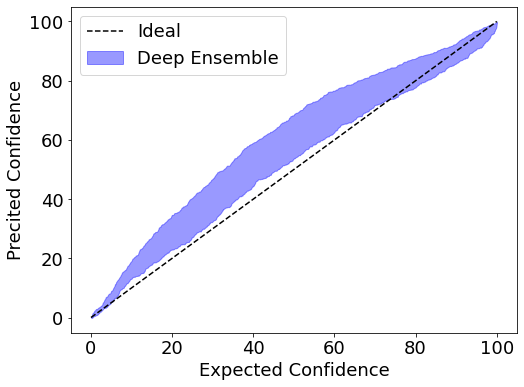

In [25]:
fig = plt.figure(figsize=(8,6))
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.fill_between(alphas,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

## UQ Model: MC Dropout

Simple MLP architecture with 10% dropout probability

In [26]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):

    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dropout(rate = 0.10)(x)
    x = Dense(10, activation = actfn)(x)
    x = Dropout(rate = 0.10)(x)
    mu = Dense(1, activation = actfn)(x)

    model = Model(feature_input, mu)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)

    return model

In [27]:
nmodels = 5
all_models_MC=[]
all_mae_train_MC = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 3000, 'sigmoid')
    all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
    all_models_MC.append(model_MC)

100% |#########################################################################|


In [28]:
select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)]
print("Train MAE: ", mae(K.get_value(select_modelMC(Xtrain_norm))*(np.max(Ytrain)), Ytrain))
print("Test1 MAE: ", mae(K.get_value(select_modelMC(Xtest1_norm))*(np.max(Ytrain)), Ytest1))
print("Test2 MAE: ", mae(K.get_value(select_modelMC(Xtest2_norm))*(np.max(Ytrain)), Ytest2))
print("Test3 MAE: ", mae(K.get_value(select_modelMC(Xtest3_norm))*(np.max(Ytrain)), Ytest3))

Train MAE:  34.077848853134526
Test1 MAE:  99.26348223005023
Test2 MAE:  253.46315689086913
Test3 MAE:  358.58651462131076


In [29]:
allresults_MCdf = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nmodels_select):
        result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

    allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodels_select)

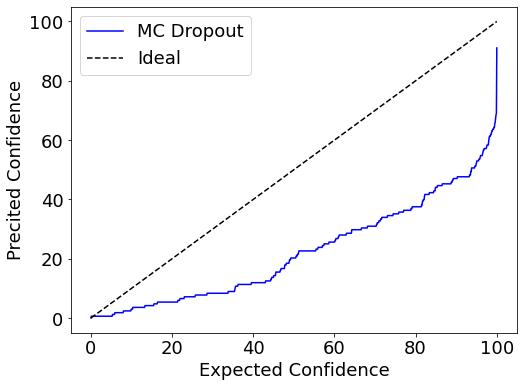

In [30]:
alphas, CI_DE = get_confidence_interval(allresults_MCdf['True'].values, 
                                       allresults_MCdf['MC_mu_eff'].values, 
                                       allresults_MCdf['MC_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

In [31]:
## Repeat 10 times
nmodels = 5 # total models trained and best one picked
nmodels_select = 5 # run 5 times per each select model with dropout
niter = 10

allCI_MC = np.zeros((1000, niter))
pbar=ProgressBar()

for myiter in pbar(range(niter)):
    all_models_MC=[]
    all_mae_train_MC = np.zeros(nmodels,)
    pbar = ProgressBar()
    for i in range(nmodels):
        model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 3000, 'sigmoid')
        all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
        all_models_MC.append(model_MC)

    select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)]

    allresults_MCdf = pd.DataFrame()
    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        for i in range(nmodels_select):
            result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

        allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
    allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodels_select)

    alphas, CI_MC = get_confidence_interval(allresults_MCdf['True'].values, 
                                           allresults_MCdf['MC_mu_eff'].values, 
                                           allresults_MCdf['MC_sigma_eff'].values)
    allCI_MC[:,myiter] = CI_MC

100% |#########################################################################|


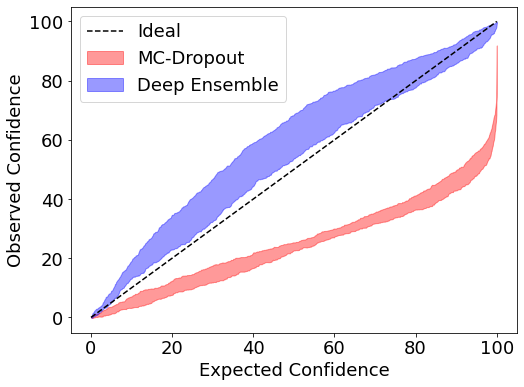

In [35]:
fig = plt.figure(figsize=(8,6))
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.fill_between(alphas,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')
plt.fill_between(alphas,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')

plt.xlabel('Expected Confidence')
plt.ylabel('Observed Confidence')
plt.legend()